<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Detection with Convolutional Neural Network

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing modules

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random

## Exploratory Data Analysis

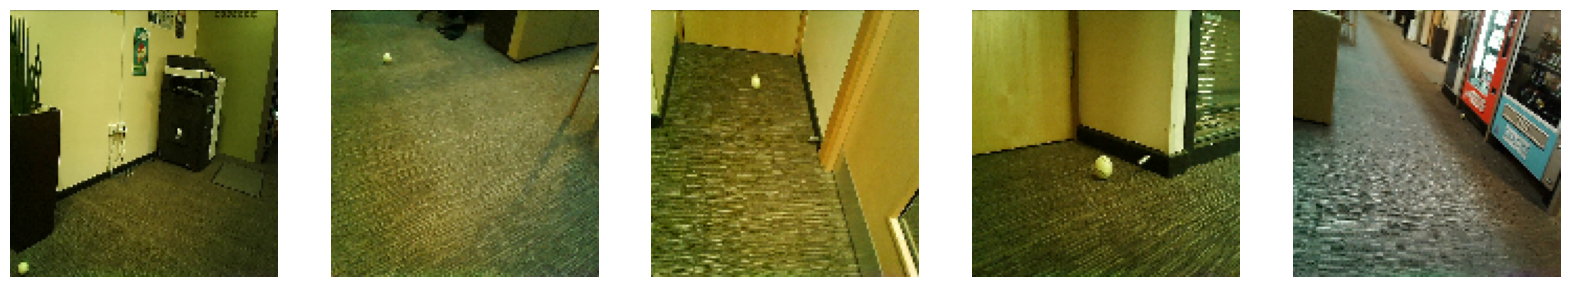

In [49]:
# Print 5 random images
image_directory = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/'
image_files = os.listdir(image_directory)
selected_images = random.sample(image_files, 5)

plt.figure(figsize=(20, 4))
for i, image_file in enumerate(selected_images):
    img_path = os.path.join(image_directory, image_file)
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

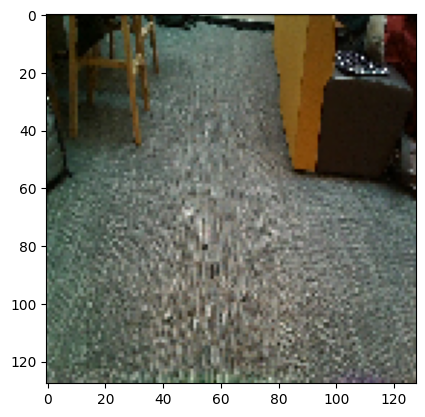

In [28]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty6.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

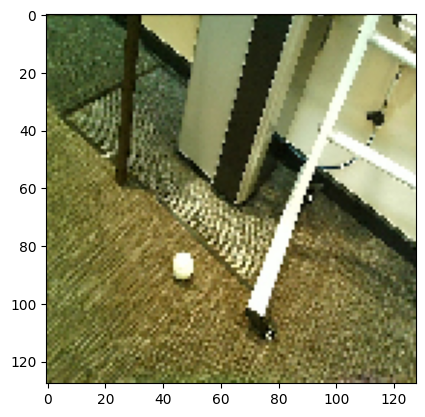

In [53]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

In [29]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

Investigating Label Distribution

In [30]:
# Converting training sets to num arrays
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [57]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

# Count the number of images in each directory
count_train_balls = len(os.listdir(dir_train_balls))
count_train_empty = len(os.listdir(dir_train_empty))
count_test_balls = len(os.listdir(dir_test_balls))
count_test_empty = len(os.listdir(dir_test_empty))

# Print out the counts
print(f'Training set - images with tennis balls: {count_train_balls}')
print(f'Training set - images without tennis balls: {count_train_empty}')
print(f'Test set - images with tennis balls: {count_test_balls}')
print(f'Test set - images without tennis balls: {count_test_empty}')

# Check balance
total_train_images = count_train_balls + count_train_empty
total_test_images = count_test_balls + count_test_empty

print(f'Total images in the training set: {total_train_images}')
print(f'Total images in the test set: {total_test_images}')

# Proportions of each class
proportion_balls_train = count_train_balls / total_train_images
proportion_empty_train = count_train_empty / total_train_images
proportion_balls_test = count_test_balls / total_test_images
proportion_empty_test = count_test_empty / total_test_images

print(f'Proportion of training images with tennis balls: {proportion_balls_train:.2f}')
print(f'Proportion of training images without tennis balls: {proportion_empty_train:.2f}')
print(f'Proportion of test images with tennis balls: {proportion_balls_test:.2f}')
print(f'Proportion of test images without tennis balls: {proportion_empty_test:.2f}')

# Evaluate balance and suggest actions
def evaluate_balance(count_with, count_without, dataset_type):
    if count_with == count_without:
        print(f'{dataset_type} set is perfectly balanced.')
    elif count_with > count_without:
        print(f'{dataset_type} set is imbalanced. Consider using techniques to increase the number of images without tennis balls.')
    else:
        print(f'{dataset_type} set is imbalanced. Consider using techniques to increase the number of images with tennis balls.')

evaluate_balance(count_train_balls, count_train_empty, "Training")
evaluate_balance(count_test_balls, count_test_empty, "Test")

Training set - images with tennis balls: 406
Training set - images without tennis balls: 417
Test set - images with tennis balls: 40
Test set - images without tennis balls: 40
Total images in the training set: 823
Total images in the test set: 80
Proportion of training images with tennis balls: 0.49
Proportion of training images without tennis balls: 0.51
Proportion of test images with tennis balls: 0.50
Proportion of test images without tennis balls: 0.50
Training set is imbalanced. Consider using techniques to increase the number of images with tennis balls.
Test set is perfectly balanced.


In [31]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [32]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [33]:
# Shuffle the combined dataset
# It's important to shuffle the data before splitting to ensure randomness
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [34]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [35]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (632, 128, 128, 3)
X_test shape: (271, 128, 128, 3)
y_train shape: (632,)
y_test shape: (271,)


In [36]:
x_train_new[400:405]

array([[[[0.39215687, 0.38039216, 0.07843138],
         [0.40392157, 0.41568628, 0.09803922],
         [0.4       , 0.4117647 , 0.09411765],
         ...,
         [0.34117648, 0.34901962, 0.10196079],
         [0.3372549 , 0.34117648, 0.11372549],
         [0.3764706 , 0.38039216, 0.12156863]],

        [[0.6       , 0.5921569 , 0.15686275],
         [0.60784316, 0.6156863 , 0.19607843],
         [0.60784316, 0.62352943, 0.19215687],
         ...,
         [0.5411765 , 0.5647059 , 0.21960784],
         [0.5294118 , 0.56078434, 0.23529412],
         [0.5176471 , 0.5372549 , 0.22352941]],

        [[0.62352943, 0.61960787, 0.19607843],
         [0.6117647 , 0.6156863 , 0.21568628],
         [0.58431375, 0.6039216 , 0.2       ],
         ...,
         [0.5294118 , 0.54901963, 0.22745098],
         [0.5372549 , 0.5686275 , 0.23529412],
         [0.5568628 , 0.5764706 , 0.24705882]],

        ...,

        [[0.23137255, 0.34117648, 0.14117648],
         [0.22745098, 0.33333334, 0.1254902 ]

In [37]:
y_train_new[400:405]

array([0., 1., 0., 1., 1.])

## Model

In [38]:
model = Sequential()

model.add(Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [39]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=10)

Epoch 1/10
20/20 [==============================] - 11s 487ms/step - loss: 0.8002 - accuracy: 0.4747 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 2/10
20/20 [==============================] - 11s 552ms/step - loss: 0.6945 - accuracy: 0.5079 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 3/10
20/20 [==============================] - 10s 529ms/step - loss: 0.6929 - accuracy: 0.5364 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 4/10
20/20 [==============================] - 9s 459ms/step - loss: 0.6934 - accuracy: 0.5111 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 5/10
20/20 [==============================] - 11s 522ms/step - loss: 0.6938 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.4945
Epoch 6/10
20/20 [==============================] - 11s 556ms/step - loss: 0.6934 - accuracy: 0.4873 - val_loss: 0.6933 - val_accuracy: 0.4945
Epoch 7/10
20/20 [==============================] - 11s 571ms/step - loss: 0.6930 - accuracy: 0.5158 - val_loss: 0.6933 - val_accuracy: 0.4945


## History

In [40]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

<Axes: >

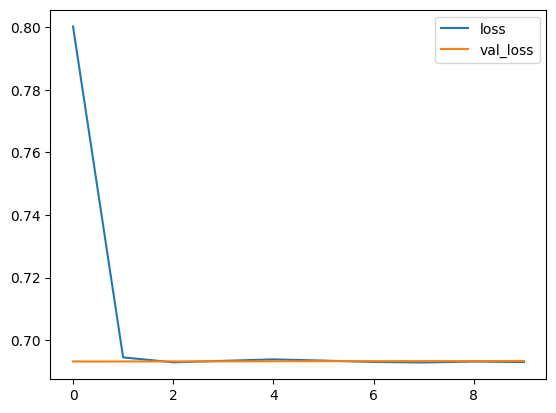

In [41]:
model_loss.plot()

<Axes: >

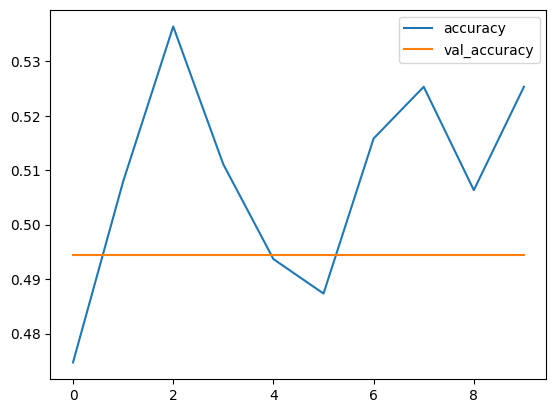

In [42]:
model_accuracy.plot()

## Model evaluation

In [43]:
predictions = np.rint(model.predict(x_test))

3/3 [==============================] - 0s 86ms/step


In [44]:
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        40
         1.0       0.00      0.00      0.00        40

    accuracy                           0.50        80
   macro avg       0.25      0.50      0.33        80
weighted avg       0.25      0.50      0.33        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
confusion_matrix(y_test, predictions)

array([[40,  0],
       [40,  0]])

Text(0.5, 1.0, 'prediction: [0.]')

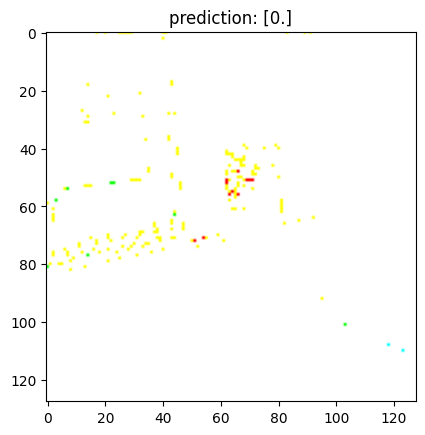

In [46]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [47]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Load model

In [48]:
model = tf.keras.models.load_model('model.h5')